# How to debug a model

There are various levels on which to debug a model. One of the simplest is to just print out the values that different variables are taking on.

Because `PyMC3` uses `Theano` expressions to build the model, and not functions, there is no way to place a `print` statement into a likelihood function. Instead, you can use the `Theano` `Print` operatator. For more information, see:  theano Print operator for this before: http://deeplearning.net/software/theano/tutorial/debug_faq.html#how-do-i-print-an-intermediate-value-in-a-function.

Let's build a simple model with just two parameters:

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]
100%|██████████| 5500/5500 [00:02<00:00, 2358.30it/s]


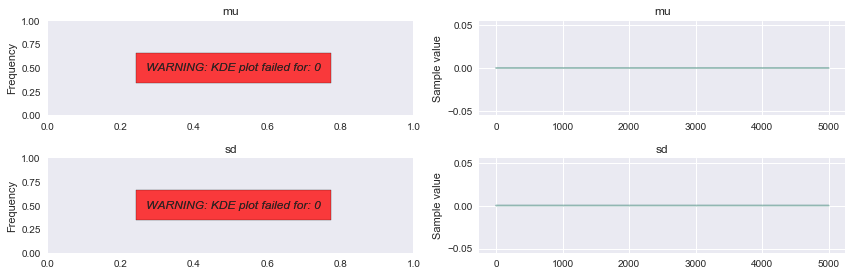

In [1]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import theano.tensor as tt

x = np.random.randn(100)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.Normal('sd', mu=0, sd=1)

    obs = pm.Normal('obs', mu=mu, sd=sd, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(5000, step)
pm.traceplot(trace);

Hm, looks like something has gone wrong, but what? Let's look at the values getting proposed using the `Print` operator:

In [2]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.Normal('sd', mu=0, sd=1)
    
    mu_print = tt.printing.Print('mu')(mu)
    sd_print = tt.printing.Print('sd')(sd)
    
    obs = pm.Normal('obs', mu=mu_print, sd=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(3, step, tune=0, chains=1, progressbar=False) # Make sure not to draw too many samples

mu __str__ = 0.0
sd __str__ = 0.0


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]


sd __str__ = 1.4406091401518182
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = -0.7642399016472413
mu __str__ = 0.0
sd __str__ = -0.12899381409884816
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 1.2614994475439572
mu __str__ = 0.0
sd __str__ = 0.7329434719007808
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.9331983611718919
mu __str__ = 0.0


In the code above, we set the `tune=0, chains=1, progressbar=False` in the `pm.sample`, this is done so that the output is cleaner.

Looks like `sd` is always `0` which will cause the logp to go to `-inf`. Of course, we should not have used a prior that has negative mass for `sd` but instead something like a `HalfNormal`.

We can also redirect the output to a string buffer and access the proposed values later on (thanks to [Lindley Lentati](https://github.com/LindleyLentati) for providing this example):

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]


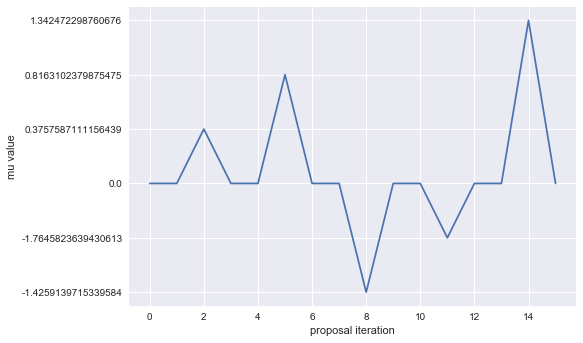

In [3]:
from io import StringIO
import sys

x = np.random.randn(100)

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sd = pm.Normal('sd', mu=0, sd=1)

    mu_print = tt.printing.Print('mu')(mu)
    sd_print = tt.printing.Print('sd')(sd)

    obs = pm.Normal('obs', mu=mu_print, sd=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(5, step, tune=0, chains=1, progressbar=False) # Make sure not to draw too many samples

sys.stdout = old_stdout

output = mystdout.getvalue().split('\n')
mulines = [s for s in output if 'mu' in s]

muvals = [line.split()[-1] for line in mulines]
plt.plot(np.arange(0, len(muvals)), muvals)
plt.xlabel('proposal iteration')
plt.ylabel('mu value');

In [4]:
trace['mu']

array([ 0.,  0.,  0.,  0.,  0.])

Notice that for each iteration, 3 values were printed and recorded. The printed values are the original value (last sample), the proposed value and the accepted value. Plus the starting value in the very beginning, we recorded in total `1+3*5=16` value above.